# EBI Metadata - General Insights

In [1]:
import pandas as pd

df = pd.read_csv('../data/metadata_EBI_preprocessed.csv',
                 dtype={'collected_by': object,
                        'collection_date': object,
                        'culture_collection': object,
                        'identified_by': object,
                        'isolate': object,
                        'isolation_source': object,
                        'keywords': object,
                        'lab_host': object,
                        'location': object,
                        'sample_accession': object,
                        'strain': object,
                        'study_accession': object})
df.info()  # 29 + 5 columns, 2.8 mio entries

c:\users\ninai\onedrive\dokumente\studium\module\master\4. semester\accountability in ai\sampling bias\sampling-bias-cov19\venv\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2831557 entries, 0 to 2831556
Data columns (total 34 columns):
 #   Column                Dtype  
---  ------                -----  
 0   accession             object 
 1   base_count            int64  
 2   collected_by          object 
 3   collection_date       object 
 4   country_and_region    object 
 5   culture_collection    object 
 6   dataclass             object 
 7   description           object 
 8   environmental_sample  bool   
 9   first_public          object 
 10  germline              bool   
 11  host                  object 
 12  identified_by         object 
 13  isolate               object 
 14  isolation_source      object 
 15  keywords              object 
 16  lab_host              object 
 17  last_updated          object 
 18  location              object 
 19  mol_type              object 
 20  sample_accession      object 
 21  scientific_name       object 
 22  sequence_md5          object 
 23  sequenc

## Descriptive Statistics

In [177]:
import pandas_profiling
import json

# Create fancy profile report
# See https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/pages/advanced_usage.html for advanced usage
profile_ebi = pandas_profiling.ProfileReport(df,
                                             title='EBI Metadata Profiling',
                                             minimal=True,
                                             correlations={'pearson': {'calculate': True},
                                                           'spearman': {'calculate': True},
                                                           'kendall': {'calculate': True},
                                                           'phi_k': {'calculate': True},
                                                           'cramers': {'calculate': False}})

# Add definitions
with open('json_data/definitions_EBI_metadata.json') as f:
    definitions_ebi_metadata = json.load(f)
profile_ebi.config.variables.descriptions = definitions_ebi_metadata

# Save as html
profile_ebi.to_file(output_file='../data/metadata_EBI_profile.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

c:\users\ninai\onedrive\dokumente\studium\module\master\4. semester\accountability in ai\sampling bias\sampling-bias-cov19\venv\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Investigation of National Bias

In [ ]:
# Separate dataframe into countries appearing often and rarely
threshold = 1000

rare_countries = df[df['country'].map(df['country'].value_counts()) < threshold]
rare_countries['country'].value_counts()

In [ ]:
popular_countries = df[df['country'].map(df['country'].value_counts()) >= threshold]
popular_countries['country'].value_counts()

In [ ]:
with open('json_data/country_inhabitants_map.json') as f:
    country_inhabitants_map = json.load(f)

In [2]:
import os

if not os.path.isdir('../plots/general_country_counts'):
    os.mkdir('../plots/general_country_counts')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Plot distribution of countries appearing more than 1,000 times
for hue in ['dataclass', 'mol_type', 'keywords', 'gender']:
    fig, ax = plt.subplots(figsize=(18, 16))
    sns.countplot(data=popular_countries,
                  x='country',
                  hue=hue,
                  order=popular_countries['country'].value_counts().index)

    fig.suptitle('Distribution of Countries with >= 1,000 Samples', fontsize=22)
    plt.xlabel('Country', fontsize=18)
    plt.ylabel('Count Normalized by Number of Inhabitants', fontsize=18)
    plt.xticks(fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper right', title=f'{hue.capitalize()}:', fontsize=14)
    plt.rcParams['legend.title_fontsize'] = 14

    # Normalize height of bars with number of inhabitants
    max_y = 0
    n_countries = len(popular_countries['country'].unique())
    hue_index = 0

    for i, patch in enumerate(ax.patches):
        if i % n_countries == 0 and i != 0:
            hue_index += 1
        country = ax.get_xticklabels()[i - (hue_index * n_countries)].get_text()

        new_height = patch.get_height() / country_inhabitants_map[country]
        max_y = max(max_y, new_height)
        patch.set_height(new_height)

    plt.gca().set_ylim([0, max_y + (max_y / 20)])

    fig.savefig(f'../plots/general_country_counts/popular_countries_count_by_{hue}_normalized.png', dpi=300)
    plt.close()

In [ ]:
# Plot distribution of countries appearing less than 1,000 times
for hue in ['dataclass', 'mol_type', 'keywords', 'gender']:
    fig, ax = plt.subplots(figsize=(36, 18))
    sns.countplot(data=rare_countries,
                  x='country',
                  hue=hue,
                  order=rare_countries['country'].value_counts().index)

    fig.suptitle('Distribution of Countries with < 1,000 Samples', fontsize=22)
    plt.xlabel('Country', fontsize=18)
    plt.ylabel('Count Normalized by Number of Inhabitants', fontsize=18)
    plt.xticks(fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper right', title=f'{hue.capitalize()}:', fontsize=14)
    plt.rcParams['legend.title_fontsize'] = 14

    # Normalize height of bars with number of inhabitants
    max_y = 0
    n_countries = len(rare_countries['country'].unique())
    hue_index = 0

    for i, patch in enumerate(ax.patches):
        if i % n_countries == 0 and i != 0:
            hue_index += 1
        country = ax.get_xticklabels()[i - (hue_index * n_countries)].get_text()

        if country == 'Unknown':
            new_height = 0.0
        else:
            new_height = patch.get_height() / country_inhabitants_map[country]

        max_y = max(max_y, new_height)
        patch.set_height(new_height)
    plt.gca().set_ylim([0, max_y + (max_y / 20)])

    fig.savefig(f'../plots/general_country_counts/rare_countries_count_by_{hue}_normalized.png', dpi=300)
    plt.close()

## Number of Infections per Country
### Preprocess Time Series Data by JHU

In [82]:
# Taken from https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
countries_ts = pd.read_csv('../data/JHU_countries_time_series.csv')
countries_ts.info()  # 280 entries, 723 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Columns: 723 entries, Province/State to 1/9/22
dtypes: float64(2), int64(719), object(2)
memory usage: 1.5+ MB


In [13]:
# Check which countries from EBI metadata do not exist in JHU data
countries_eJHU = countries_ts['Country/Region'].unique()
countries_ebi = df['country'].unique()

list(set(countries_ebi) - set(countries_eJHU))

[nan,
 'Hong Kong',
 'Puerto Rico',
 'South Korea',
 'Guam',
 'Taiwan',
 'Czech Republic',
 'Myanmar']

In [83]:
# Change countries in JHU data to EBI metadata wording
countries_ts['Country/Region'].replace(['Vietnam', 'West Bank and Gaza', 'US'], ['Viet Nam', 'West Bank', 'USA'], inplace=True)

In [14]:
countries_ts['Country/Region'].value_counts()  # -> some countries occur several times and have to be summed up first

China             34
Canada            16
United Kingdom    12
France            12
Australia          8
                  ..
Guinea             1
Guinea-Bissau      1
Guyana             1
Haiti              1
Zimbabwe           1
Name: Country/Region, Length: 196, dtype: int64

In [8]:
countries_ts[countries_ts['Country/Region'] == 'China']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/31/21,1/1/22,1/2/22,1/3/22,1/4/22,1/5/22,1/6/22,1/7/22,1/8/22,1/9/22
58,Anhui,China,31.8257,117.2264,1,9,15,39,60,70,...,1009,1009,1009,1009,1009,1009,1009,1009,1009,1009
59,Beijing,China,40.1824,116.4142,14,22,36,41,68,80,...,1211,1211,1215,1215,1216,1216,1217,1217,1218,1218
60,Chongqing,China,30.0572,107.8740,6,9,27,57,75,110,...,611,611,611,611,611,611,611,611,611,611
61,Fujian,China,26.0789,117.9874,1,5,10,18,35,59,...,1363,1372,1372,1383,1390,1396,1397,1401,1410,1415
62,Gansu,China,35.7518,104.2861,0,2,2,4,7,14,...,356,356,356,356,356,356,356,356,356,356
63,Guangdong,China,23.3417,113.4244,26,32,53,78,111,151,...,3457,3467,3467,3486,3493,3503,3512,3521,3530,3539
64,Guangxi,China,23.8298,108.7881,2,5,23,23,36,46,...,622,630,637,641,650,652,656,662,665,668
65,Guizhou,China,26.8154,106.8748,1,3,3,4,5,7,...,160,160,160,160,160,160,160,160,160,160
66,Hainan,China,19.1959,109.7453,4,5,8,19,22,33,...,190,190,190,190,190,190,190,190,190,190
67,Hebei,China,39.5490,116.1306,1,1,2,8,13,18,...,1458,1458,1458,1458,1458,1458,1458,1458,1458,1458


In [84]:
# Get countries whose time series values have to be summed up
countries_to_sum = countries_ts['Country/Region'].value_counts().reset_index(name="count").query("count > 1")["index"]
countries_to_sum

0             China
1            Canada
2    United Kingdom
3            France
4         Australia
5       Netherlands
6           Denmark
7       New Zealand
Name: index, dtype: object

In [20]:
# Exclude first 4 columns (meaning 'Province/State', 'Country/Region', 'Lat' and 'Long')
date_cols = countries_ts.columns.tolist()[4:]
date_cols

['1/22/20',
 '1/23/20',
 '1/24/20',
 '1/25/20',
 '1/26/20',
 '1/27/20',
 '1/28/20',
 '1/29/20',
 '1/30/20',
 '1/31/20',
 '2/1/20',
 '2/2/20',
 '2/3/20',
 '2/4/20',
 '2/5/20',
 '2/6/20',
 '2/7/20',
 '2/8/20',
 '2/9/20',
 '2/10/20',
 '2/11/20',
 '2/12/20',
 '2/13/20',
 '2/14/20',
 '2/15/20',
 '2/16/20',
 '2/17/20',
 '2/18/20',
 '2/19/20',
 '2/20/20',
 '2/21/20',
 '2/22/20',
 '2/23/20',
 '2/24/20',
 '2/25/20',
 '2/26/20',
 '2/27/20',
 '2/28/20',
 '2/29/20',
 '3/1/20',
 '3/2/20',
 '3/3/20',
 '3/4/20',
 '3/5/20',
 '3/6/20',
 '3/7/20',
 '3/8/20',
 '3/9/20',
 '3/10/20',
 '3/11/20',
 '3/12/20',
 '3/13/20',
 '3/14/20',
 '3/15/20',
 '3/16/20',
 '3/17/20',
 '3/18/20',
 '3/19/20',
 '3/20/20',
 '3/21/20',
 '3/22/20',
 '3/23/20',
 '3/24/20',
 '3/25/20',
 '3/26/20',
 '3/27/20',
 '3/28/20',
 '3/29/20',
 '3/30/20',
 '3/31/20',
 '4/1/20',
 '4/2/20',
 '4/3/20',
 '4/4/20',
 '4/5/20',
 '4/6/20',
 '4/7/20',
 '4/8/20',
 '4/9/20',
 '4/10/20',
 '4/11/20',
 '4/12/20',
 '4/13/20',
 '4/14/20',
 '4/15/20',
 '4/16/

In [85]:
for country in countries_to_sum:
    country_ts = countries_ts[countries_ts['Country/Region'] == country]
    # Sum up column values for each date column
    country_ts.loc['Country_Total'] = country_ts[date_cols].sum(axis=0)
    # Mark "special" country with suffix
    country_ts.loc['Country_Total', 'Country/Region'] = f'{country}_Sum'
    # Append new row to existing time series data frame
    countries_ts = pd.concat([countries_ts, country_ts], axis=0)

c:\users\ninai\onedrive\dokumente\studium\module\master\4. semester\accountability in ai\sampling bias\sampling-bias-cov19\venv\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
c:\users\ninai\onedrive\dokumente\studium\module\master\4. semester\accountability in ai\sampling bias\sampling-bias-cov19\venv\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [32]:
# Show example of new row
countries_ts[countries_ts['Country/Region'] == 'China_Sum']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/31/21,1/1/22,1/2/22,1/3/22,1/4/22,1/5/22,1/6/22,1/7/22,1/8/22,1/9/22
Country_Total,NaN,China_Sum,NaN,NaN,548.0,643.0,920.0,1406.0,2075.0,2877.0,...,115042.0,115251.0,115409.0,115597.0,115701.0,115908.0,116106.0,116282.0,116468.0,116641.0


In [86]:
# Filter for countries that appear only one time (which is also true for countries that appeared several times before because suffix "_Sum" makes country name unique)
relevant_countries = countries_ts['Country/Region'].value_counts().reset_index(name="count").query("count == 1")["index"]
countries_ts = countries_ts[countries_ts['Country/Region'].isin(relevant_countries)]

# Remove suffix after filtering of relevant countries and reset index
countries_ts['Country/Region'] = countries_ts['Country/Region'].str.replace('_Sum', '')
countries_ts.reset_index(drop=True, inplace=True)

In [65]:
countries_ts['Country/Region'].nunique()  # -> all countries are still there

196

In [100]:
countries_ts.to_csv('../data/JHU_countries_time_series_preprocessed.csv', index=False)

### Number of Samples in Relation to Current Number of Infections per Country

In [ ]:
countries_ts = pd.read_csv('../data/JHU_countries_time_series_preprocessed.csv')

In [142]:
# Get count of each country
country_counts = pd.DataFrame(df['country'].value_counts().sort_index())
country_counts.reset_index(level=0, inplace=True)
country_counts.rename(columns={'index': 'Country', 'country': 'Count'}, inplace=True)
country_counts

,Country,Count
0,Argentina,43
1,Armenia,48
2,Australia,13311
3,Austria,261
4,Bahrain,3304
...,...,...
102,Venezuela,40
103,Viet Nam,11
104,West Bank,63
105,Zambia,1


In [92]:
import numpy as np

def add_infection(country):
    if country in countries_ts['Country/Region'].unique():
        return countries_ts[countries_ts['Country/Region'] == country]['1/9/22'].iloc[0]
    else:
        return np.nan

country_counts['Infections'] = country_counts.apply(lambda row: add_infection(str(row['Country'])), axis=1)
country_counts

,Country,Count,Infections
0,Argentina,43,6310844.0
1,Armenia,48,345855.0
2,Australia,13311,1045291.0
3,Austria,261,1339421.0
4,Bahrain,3304,292572.0
...,...,...,...
102,Venezuela,40,447288.0
103,Viet Nam,11,1899575.0
104,West Bank,63,471414.0
105,Zambia,1,282904.0


In [93]:
# Add column showing #samples/#infections ratio per country
country_counts['Count_Infection_Ratio'] = country_counts['Count'] / country_counts['Infections']
country_counts

,Country,Count,Infections,Count_Infection_Ratio
0,Argentina,43,6310844.0,0.000007
1,Armenia,48,345855.0,0.000139
2,Australia,13311,1045291.0,0.012734
3,Austria,261,1339421.0,0.000195
4,Bahrain,3304,292572.0,0.011293
...,...,...,...,...
102,Venezuela,40,447288.0,0.000089
103,Viet Nam,11,1899575.0,0.000006
104,West Bank,63,471414.0,0.000134
105,Zambia,1,282904.0,0.000004


In [96]:
# Remove countries that did not occur in time series data from JUH
plotdata = country_counts[country_counts['Infections'] != np.nan]

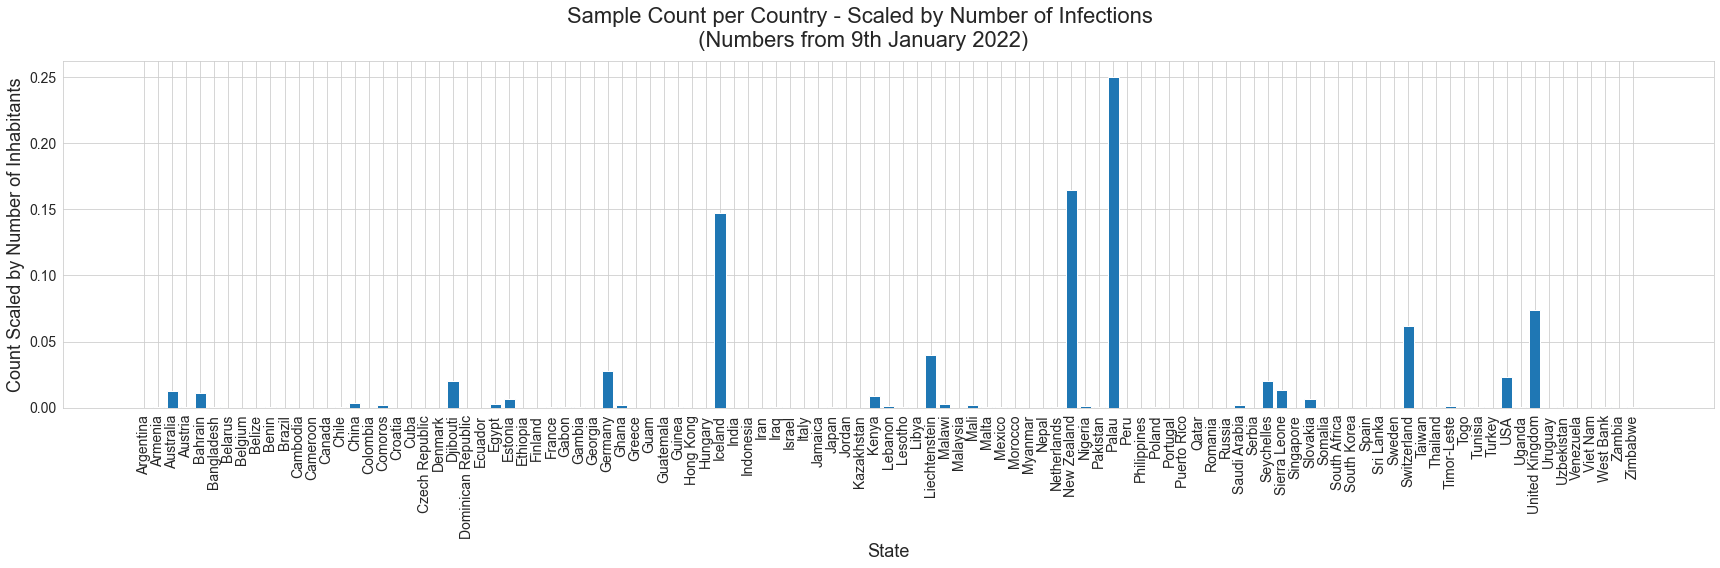

In [98]:
# Generate bar plots with #samples/#infections on y-axis and country on x-axis
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, _ = plt.subplots(figsize=(24, 8))
plt.bar(plotdata['Country'].tolist(), plotdata['Count_Infection_Ratio'].tolist())

fig.suptitle('Sample Count per Country - Scaled by Number of Infections\n (Numbers from 9th January 2022)', fontsize=22)
plt.xlabel('State', fontsize=18)
plt.ylabel('Count Scaled by Number of Inhabitants', fontsize=18)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)

plt.tight_layout()
fig.savefig('../plots/country_counts_by_infections.png', dpi=300)
plt.close()

### Number of Samples in Relation to Number of Infections per Country: Week-wise over Time

In [2]:
countries_ts = pd.read_csv('../data/JHU_countries_time_series_preprocessed.csv')
countries_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Columns: 723 entries, Province/State to 1/9/22
dtypes: float64(722), object(1)
memory usage: 1.1+ MB


In [3]:
# Remove some date columns to start on first Monday in dataset
countries_ts = countries_ts.drop(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20'], axis=1)
countries_ts.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/27/20', '1/28/20',
       '1/29/20', '1/30/20', '1/31/20', '2/1/20',
       ...
       '12/31/21', '1/1/22', '1/2/22', '1/3/22', '1/4/22', '1/5/22', '1/6/22',
       '1/7/22', '1/8/22', '1/9/22'],
      dtype='object', length=718)

In [4]:
# Sum up infection count per week (starting with week from 1/27/20)
for i, date_col in enumerate(countries_ts.columns[4:717:7]):
    countries_ts[f'{date_col}_Week'] = countries_ts.iloc[:, i*7 : i*7 + 7].mean(axis=1)

c:\users\ninai\onedrive\dokumente\studium\module\master\4. semester\accountability in ai\sampling bias\sampling-bias-cov19\venv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\ninai\onedrive\dokumente\studium\module\master\4. semester\accountability in ai\sampling bias\sampling-bias-cov19\venv\lib\site-packages\ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until


In [306]:
countries_ts[['Country/Region', '1/3/22', '1/4/22', '1/5/22', '1/6/22', '1/7/22', '1/8/22', '1/9/22', '1/3/22_Week']]

,Country/Region,1/3/22,1/4/22,1/5/22,1/6/22,1/7/22,1/8/22,1/9/22,1/3/22_Week
0,Afghanistan,158183.0,158205.0,158245.0,158275.0,158300.0,158309.0,158381.0,1.581527e+05
1,Albania,210885.0,212021.0,212021.0,213257.0,214905.0,214905.0,219694.0,2.107370e+05
2,Algeria,219532.0,219953.0,220415.0,220825.0,221316.0,221742.0,222157.0,2.191923e+05
3,Andorra,24502.0,24802.0,25289.0,25289.0,26408.0,26408.0,26408.0,2.413357e+04
4,Angola,83764.0,84666.0,86636.0,87625.0,88775.0,89251.0,89718.0,8.312114e+04
...,...,...,...,...,...,...,...,...,...
191,France,10422830.0,10694804.0,11027112.0,11290010.0,11623327.0,11921925.0,12218022.0,1.038862e+07
192,Australia,537308.0,608803.0,684229.0,762458.0,860550.0,972457.0,1045291.0,5.119914e+05
193,Netherlands,3234143.0,3254947.0,3282146.0,3309168.0,3346598.0,3376251.0,3410288.0,3.219719e+06
194,Denmark,849334.0,874890.0,903652.0,929647.0,948499.0,961591.0,982189.0,8.432357e+05


In [5]:
# Keep weekly data and country
plotdata_infections = countries_ts.filter(regex='_Week$|Country/Region', axis=1)
# Remove suffix from date column names for interpretability on x-axis later on
plotdata_infections.columns = plotdata_infections.columns.str.replace('_Week', '')

plotdata_infections.head(10)

,Country/Region,1/27/20,2/3/20,2/10/20,2/17/20,2/24/20,3/2/20,3/9/20,3/16/20,3/23/20,...,11/1/21,11/8/21,11/15/21,11/22/21,11/29/21,12/6/21,12/13/21,12/20/21,12/27/21,1/3/22
0,Afghanistan,20.329813,0.0,0.0,0.0,2.142857,5.000000,7.571429,19.000000,37.714286,...,1.562480e+05,1.563939e+05,1.565719e+05,1.568956e+05,1.572330e+05,1.574619e+05,1.576293e+05,1.577779e+05,1.579447e+05,1.581527e+05
1,Albania,12.264320,0.0,0.0,0.0,0.000000,0.000000,3.428571,43.000000,96.000000,...,1.852731e+05,1.889673e+05,1.929607e+05,1.962963e+05,1.993691e+05,2.016649e+05,2.037489e+05,2.057520e+05,2.077667e+05,2.107370e+05
2,Algeria,5.938700,0.0,0.0,0.0,0.285714,3.428571,17.857143,46.142857,187.571429,...,2.064584e+05,2.071794e+05,2.079943e+05,2.089821e+05,2.101673e+05,2.114810e+05,2.128624e+05,2.145887e+05,2.166680e+05,2.191923e+05
3,Andorra,8.805620,0.0,0.0,0.0,0.000000,0.428571,1.000000,12.000000,116.285714,...,1.552243e+04,1.566257e+04,1.585843e+04,1.619429e+04,1.685071e+04,1.827843e+04,1.961486e+04,2.081314e+04,2.206514e+04,2.413357e+04
4,Angola,1.334240,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2.000000,...,6.440171e+04,6.468914e+04,6.490929e+04,6.502729e+04,6.514629e+04,6.526086e+04,6.541686e+04,6.615214e+04,7.264157e+04,8.312114e+04
5,Antigua and Barbuda,-8.947120,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.857143,1.857143,...,4.056571e+03,4.088000e+03,4.116143e+03,4.134571e+03,4.141000e+03,4.146857e+03,4.163857e+03,4.194857e+03,4.240143e+03,4.341000e+03
6,Argentina,-20.406560,0.0,0.0,0.0,0.000000,0.285714,10.142857,47.428571,246.285714,...,5.289195e+06,5.297241e+06,5.306239e+06,5.315605e+06,5.327138e+06,5.341511e+06,5.360068e+06,5.392860e+06,5.476772e+06,5.729438e+06
7,Armenia,17.021460,0.0,0.0,0.0,0.000000,0.571429,1.000000,38.571429,193.428571,...,3.078230e+05,3.198483e+05,3.285063e+05,3.338926e+05,3.377780e+05,3.405740e+05,3.424531e+05,3.435999e+05,3.444533e+05,3.450229e+05
8,Austria,12.413260,0.0,0.0,0.0,0.571429,13.857143,119.714286,902.428571,3734.571429,...,8.303744e+05,8.833756e+05,9.593736e+05,1.054796e+06,1.141182e+06,1.197204e+06,1.228382e+06,1.249461e+06,1.264701e+06,1.286942e+06
9,Azerbaijan,17.544000,0.0,0.0,0.0,0.000000,1.714286,8.714286,21.142857,65.428571,...,5.309299e+05,5.464500e+05,5.602343e+05,5.735141e+05,5.854266e+05,5.960063e+05,6.041276e+05,6.101781e+05,6.145023e+05,6.176463e+05


In [6]:
# Remove invalid number of infections
plotdata_infections._get_numeric_data()[plotdata_infections._get_numeric_data() < 0] = 0
plotdata_infections.head(10)

,Country/Region,1/27/20,2/3/20,2/10/20,2/17/20,2/24/20,3/2/20,3/9/20,3/16/20,3/23/20,...,11/1/21,11/8/21,11/15/21,11/22/21,11/29/21,12/6/21,12/13/21,12/20/21,12/27/21,1/3/22
0,Afghanistan,20.329813,0.0,0.0,0.0,2.142857,5.000000,7.571429,19.000000,37.714286,...,1.562480e+05,1.563939e+05,1.565719e+05,1.568956e+05,1.572330e+05,1.574619e+05,1.576293e+05,1.577779e+05,1.579447e+05,1.581527e+05
1,Albania,12.264320,0.0,0.0,0.0,0.000000,0.000000,3.428571,43.000000,96.000000,...,1.852731e+05,1.889673e+05,1.929607e+05,1.962963e+05,1.993691e+05,2.016649e+05,2.037489e+05,2.057520e+05,2.077667e+05,2.107370e+05
2,Algeria,5.938700,0.0,0.0,0.0,0.285714,3.428571,17.857143,46.142857,187.571429,...,2.064584e+05,2.071794e+05,2.079943e+05,2.089821e+05,2.101673e+05,2.114810e+05,2.128624e+05,2.145887e+05,2.166680e+05,2.191923e+05
3,Andorra,8.805620,0.0,0.0,0.0,0.000000,0.428571,1.000000,12.000000,116.285714,...,1.552243e+04,1.566257e+04,1.585843e+04,1.619429e+04,1.685071e+04,1.827843e+04,1.961486e+04,2.081314e+04,2.206514e+04,2.413357e+04
4,Angola,1.334240,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2.000000,...,6.440171e+04,6.468914e+04,6.490929e+04,6.502729e+04,6.514629e+04,6.526086e+04,6.541686e+04,6.615214e+04,7.264157e+04,8.312114e+04
5,Antigua and Barbuda,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.857143,1.857143,...,4.056571e+03,4.088000e+03,4.116143e+03,4.134571e+03,4.141000e+03,4.146857e+03,4.163857e+03,4.194857e+03,4.240143e+03,4.341000e+03
6,Argentina,0.000000,0.0,0.0,0.0,0.000000,0.285714,10.142857,47.428571,246.285714,...,5.289195e+06,5.297241e+06,5.306239e+06,5.315605e+06,5.327138e+06,5.341511e+06,5.360068e+06,5.392860e+06,5.476772e+06,5.729438e+06
7,Armenia,17.021460,0.0,0.0,0.0,0.000000,0.571429,1.000000,38.571429,193.428571,...,3.078230e+05,3.198483e+05,3.285063e+05,3.338926e+05,3.377780e+05,3.405740e+05,3.424531e+05,3.435999e+05,3.444533e+05,3.450229e+05
8,Austria,12.413260,0.0,0.0,0.0,0.571429,13.857143,119.714286,902.428571,3734.571429,...,8.303744e+05,8.833756e+05,9.593736e+05,1.054796e+06,1.141182e+06,1.197204e+06,1.228382e+06,1.249461e+06,1.264701e+06,1.286942e+06
9,Azerbaijan,17.544000,0.0,0.0,0.0,0.000000,1.714286,8.714286,21.142857,65.428571,...,5.309299e+05,5.464500e+05,5.602343e+05,5.735141e+05,5.854266e+05,5.960063e+05,6.041276e+05,6.101781e+05,6.145023e+05,6.176463e+05


In [7]:
# Transpose data frame with country being index
plotdata = plotdata_infections.set_index('Country/Region').T
plotdata.head()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Austria,Azerbaijan,...,Zambia,Zimbabwe,China,Canada,United Kingdom,France,Australia,Netherlands,Denmark,New Zealand
1/27/20,20.329813,12.26432,5.938700,8.80562,1.33424,0.0,0.0,17.02146,12.413260,17.544,...,2.943087,2.027884,4824.333333,1.666667,0.000000,4.000000,5.333333,0.0,0.0,0.0
2/3/20,0.000000,0.00000,0.000000,0.00000,0.00000,0.0,0.0,0.00000,0.000000,0.000,...,0.000000,0.000000,16761.000000,3.857143,4.428571,5.714286,11.428571,0.0,0.0,0.0
2/10/20,0.000000,0.00000,0.000000,0.00000,0.00000,0.0,0.0,0.00000,0.000000,0.000,...,0.000000,0.000000,38977.000000,6.714286,12.857143,9.571429,14.857143,0.0,0.0,0.0
2/17/20,0.000000,0.00000,0.000000,0.00000,0.00000,0.0,0.0,0.00000,0.000000,0.000,...,0.000000,0.000000,69491.857143,7.428571,18.428571,11.714286,15.000000,0.0,0.0,0.0
2/24/20,2.142857,0.00000,0.285714,0.00000,0.00000,0.0,0.0,0.00000,0.571429,0.000,...,0.000000,0.000000,76830.142857,9.857143,28.142857,13.142857,15.000000,0.0,0.0,0.0


<AxesSubplot:>

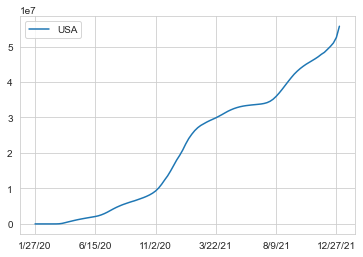

In [348]:
plotdata['USA'].plot(legend=True)

In [8]:
# Remove data before 1/27/20 from EBI metadata
df['collection_date'] = pd.to_datetime(df['collection_date'])
df_relevant_dates = df[~(df['collection_date'] < '2020-01-27')]

In [9]:
# Get count per country over time
country_counts = df_relevant_dates.groupby(['country', 'collection_date']).size().reset_index()
country_counts.rename(columns={0 : 'count'}, inplace=True)
country_counts

,country,collection_date,count
0,Argentina,2020-05-16,1
1,Argentina,2020-06-04,23
2,Argentina,2020-09-13,2
3,Argentina,2020-09-14,8
4,Argentina,2020-09-15,2
...,...,...,...
8936,Zambia,2020-03-16,1
8937,Zimbabwe,2020-03-01,8
8938,Zimbabwe,2020-04-01,14
8939,Zimbabwe,2020-05-01,35


In [10]:
# Prepare counts: add wanted dates as index
country_counts_prepared = pd.DataFrame(index=plotdata.index.tolist())
country_counts_prepared

""
1/27/20
2/3/20
2/10/20
2/17/20
2/24/20
...
12/6/21
12/13/21
12/20/21
12/27/21


In [11]:
# Prepare counts: add column per country holding count nearest to index date
for country in country_counts['country'].unique():
    country_counts_prepared[str(country)] = 0
    country_rows = country_counts[country_counts['country'] == country]

    for date in country_counts_prepared.index:
        date_dt = pd.to_datetime(date)
        row_idx = (abs(country_rows.iloc[:, 1] - date_dt)).idxmin()
        country_counts_prepared[country][date] = country_counts['count'][row_idx]

c:\users\ninai\onedrive\dokumente\studium\module\master\4. semester\accountability in ai\sampling bias\sampling-bias-cov19\venv\lib\site-packages\ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
country_counts_prepared.tail()

,Argentina,Armenia,Australia,Austria,Bahrain,Bangladesh,Belarus,Belgium,Belize,Benin,...,USA,Uganda,United Kingdom,Uruguay,Uzbekistan,Venezuela,Viet Nam,West Bank,Zambia,Zimbabwe
12/6/21,1,2,1,1,235,1,1,1,1,2,...,1093,2,1,2,7,1,1,19,1,41
12/13/21,1,2,1,1,235,1,1,1,1,2,...,3,2,1,2,7,1,1,19,1,41
12/20/21,1,2,1,1,235,1,1,1,1,2,...,3,2,1,2,7,1,1,19,1,41
12/27/21,1,2,1,1,235,1,1,1,1,2,...,3,2,1,2,7,1,1,19,1,41
1/3/22,1,2,1,1,235,1,1,1,1,2,...,3,2,1,2,7,1,1,19,1,41


In [13]:
# Add column for each country holding #samples/#infections ratio
for country in countries_ts['Country/Region'].unique():
    if country in country_counts_prepared.columns:
        plotdata[f'{country}_Ratio'] = country_counts_prepared[[country]] / plotdata[[country]]
    else:
        plotdata[f'{country}_Ratio'] = 0

In [380]:
plotdata[['USA_Ratio']]

Country/Region,USA_Ratio
1/27/20,inf
2/3/20,1.111111e-01
2/10/20,8.139535e-02
2/17/20,5.714286e-01
2/24/20,4.454545e-01
...,...
12/6/21,2.222713e-05
12/13/21,5.997698e-08
12/20/21,5.882925e-08
12/27/21,5.707433e-08


In [15]:
import numpy as np

# Replace inf values with NaN values -> occur if #infection was zero
plotdata.replace([np.inf, -np.inf], 0, inplace=True)

In [16]:
# Remove columns where all values are NaNs
plotdata = plotdata.dropna(axis=1, how='all')
plotdata.head()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Austria,Azerbaijan,...,Zambia_Ratio,Zimbabwe_Ratio,China_Ratio,Canada_Ratio,United Kingdom_Ratio,France_Ratio,Australia_Ratio,Netherlands_Ratio,Denmark_Ratio,New Zealand_Ratio
1/27/20,20.329813,12.26432,5.938700,8.80562,1.33424,0.0,0.0,17.02146,12.413260,17.544,...,0.339779,3.944999,0.001244,0.600000,0.000000,20.250000,0.750000,0.0,0.0,0.0
2/3/20,0.000000,0.00000,0.000000,0.00000,0.00000,0.0,0.0,0.00000,0.000000,0.000,...,0.000000,0.000000,0.000418,0.259259,2.032258,14.175000,0.087500,0.0,0.0,0.0
2/10/20,0.000000,0.00000,0.000000,0.00000,0.00000,0.0,0.0,0.00000,0.000000,0.000,...,0.000000,0.000000,0.000051,0.148936,0.700000,8.462687,0.067308,0.0,0.0,0.0
2/17/20,0.000000,0.00000,0.000000,0.00000,0.00000,0.0,0.0,0.00000,0.000000,0.000,...,0.000000,0.000000,0.000014,0.134615,0.054264,6.914634,0.133333,0.0,0.0,0.0
2/24/20,2.142857,0.00000,0.285714,0.00000,0.00000,0.0,0.0,0.00000,0.571429,0.000,...,0.000000,0.000000,0.000039,0.101449,0.035533,6.163043,0.066667,0.0,0.0,0.0


In [ ]:
import os

if not os.path.isdir('../plots/n_samples_by_infections_weekly'):
    os.mkdir('../plots/n_samples_by_infections_weekly')

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Generate one line plot per country showing #samples/#infections week-wise over time
for country in countries_ts['Country/Region'].unique():
    if country not in country_counts_prepared.columns: continue

    fig, ax = plt.subplots(figsize=(24, 12))
    plotdata[f'{country}_Ratio'].plot()

    fig.suptitle(f'Weekly Average of Sample Count of {country} - Scaled by Number of Infections', fontsize=22)
    plt.xlabel('Start Date of Week', fontsize=18)
    plt.ylabel('Scaled Count', fontsize=18)
    plt.xticks(fontsize=14, rotation=90)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    fig.savefig(f'../plots/n_samples_by_infections_weekly/weekly_count_by_infections_{country}.png', dpi=300)
    plt.close()

### Number of Samples in Relation to Number of Infections per Country: Shifted Week-wise over Time

In [39]:
# Shift number of infections one week "to the front"
cols_to_shift = plotdata.loc[:, ~plotdata.columns.str.endswith('_Ratio')]

for col in cols_to_shift:
    plotdata[[col]] = plotdata[[col]].shift(periods=-1)

plotdata[['USA']]  # -> infections numbers are shifted by one row from now on, reset "plotdata" with cells above if needed

Country/Region,USA
1/27/20,9.000000e+00
2/3/20,1.228571e+01
2/10/20,1.400000e+01
2/17/20,1.571429e+01
2/24/20,4.671429e+01
...,...
12/6/21,5.001919e+07
12/13/21,5.099504e+07
12/20/21,5.256303e+07
12/27/21,5.571927e+07


In [40]:
# Add column for each country holding #samples/#infections ratio
for country in countries_ts['Country/Region'].unique():
    if country in country_counts_prepared.columns:
        plotdata[f'{country}_Ratio_Shifted'] = country_counts_prepared[[country]] / plotdata[[country]]
    else:
        plotdata[f'{country}_Ratio_Shifted'] = 0

In [41]:
# Replace inf values with NaN values -> occur if #infection was zero
plotdata.replace([np.inf, -np.inf], 0, inplace=True)

# Remove columns where all values are NaNs
plotdata = plotdata.dropna(axis=1, how='all')
plotdata.head()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Austria,Azerbaijan,...,Zambia_Ratio_Shifted,Zimbabwe_Ratio_Shifted,China_Ratio_Shifted,Canada_Ratio_Shifted,United Kingdom_Ratio_Shifted,France_Ratio_Shifted,Australia_Ratio_Shifted,Netherlands_Ratio_Shifted,Denmark_Ratio_Shifted,New Zealand_Ratio_Shifted
1/27/20,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000358,0.259259,2.032258,14.175000,0.350000,0.000000,0.000000,0.000
2/3/20,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000180,0.148936,0.700000,8.462687,0.067308,0.000000,0.000000,0.000
2/10/20,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000029,0.134615,0.488372,6.914634,0.066667,0.000000,0.000000,0.000
2/17/20,2.142857,0.0,0.285714,0.000000,0.0,0.0,0.000000,0.000000,0.571429,0.000000,...,0.0,0.0,0.000013,0.101449,0.035533,6.163043,0.133333,0.000000,0.000000,0.000
2/24/20,5.000000,0.0,3.428571,0.428571,0.0,0.0,0.285714,0.571429,13.857143,1.714286,...,0.0,0.0,0.000038,0.037433,0.008495,0.558071,0.034483,0.071429,0.233333,0.875


In [42]:
if not os.path.isdir('../plots/n_samples_by_infections_weekly_shifted'):
    os.mkdir('../plots/n_samples_by_infections_weekly_shifted')

In [ ]:
sns.set_style('whitegrid')

# Generate one line plot per country showing #samples/#infections week-wise shifted over time
for country in countries_ts['Country/Region'].unique():
    if country not in country_counts_prepared.columns: continue

    fig, ax = plt.subplots(figsize=(24, 12))
    plotdata[f'{country}_Ratio_Shifted'].plot()

    fig.suptitle(f'Weekly Average of Sample Count of {country} - Scaled by Number of Infections from Last Week', fontsize=22)
    plt.xlabel('Start Date of Week', fontsize=18)
    plt.ylabel('Scaled Count', fontsize=18)
    plt.xticks(fontsize=14, rotation=90)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    fig.savefig(f'../plots/n_samples_by_infections_weekly_shifted/weekly_count_by_last_weeks_infections_{country}.png', dpi=300)
    plt.close()

## Investigation of Temporal Bias

In [18]:
plotdata = df.copy(deep=True)
plotdata['collection_date'] = pd.to_datetime(plotdata['collection_date'])

In [3]:
import os

if not os.path.isdir('../plots/n_samples_over_time'):
    os.mkdir('../plots/n_samples_over_time')

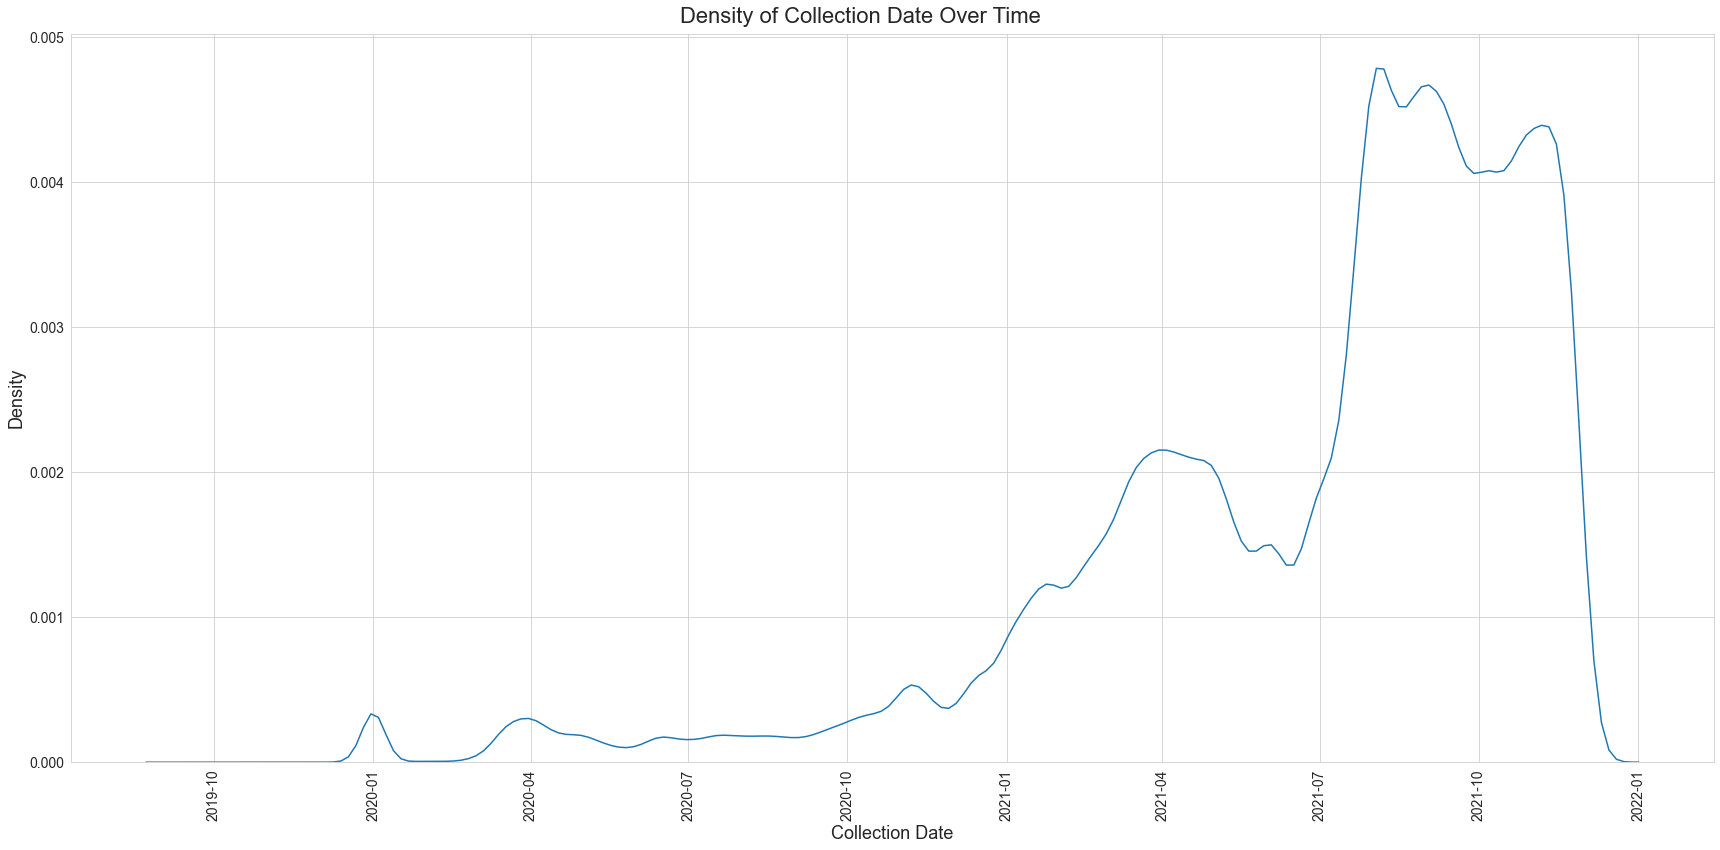

In [19]:
# A) Plot density
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, _ = plt.subplots(figsize=(24, 12))
sns.kdeplot(data=plotdata,
            x='collection_date') #,
            #hue='keywords')
fig.suptitle('Density of Collection Date Over Time', fontsize=22)
plt.xlabel('Collection Date', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)

plt.tight_layout()
fig.savefig('../plots/n_samples_over_time/collection_date_density.png', dpi=300)
plt.close()

In [20]:
# B) Plot absolute count
date_counts = plotdata.groupby(['collection_date']).count().sum(axis=1)
# date_counts = plotdata.groupby(['collection_date', 'keywords']).count().sum(axis=1)
date_counts = pd.DataFrame(date_counts, columns=['Count'])
date_counts.sort_values(by='Count', ascending=False)

,Count
collection_date,
2021-08-31,443839
2021-09-07,414717
2021-08-03,405730
2021-08-02,394096
2021-08-05,391909
...,...
2020-01-09,23
2019-09-12,23
2020-01-11,22


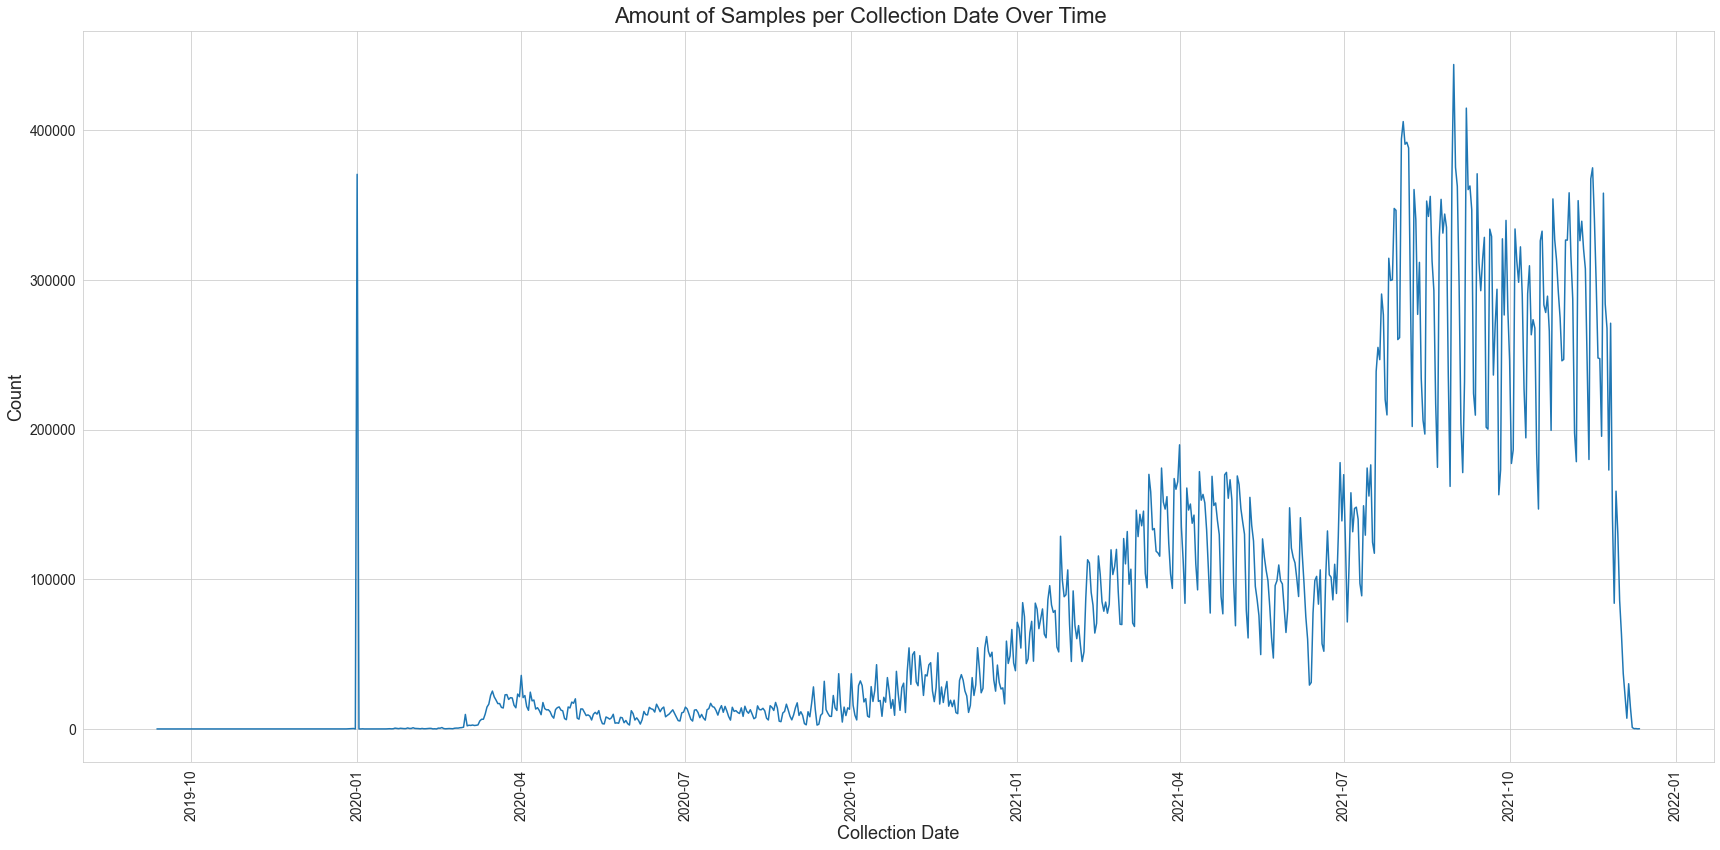

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, _ = plt.subplots(figsize=(24, 12))
sns.lineplot(x=date_counts.index, #.get_level_values(0),
             y=date_counts['Count']) #,
             #hue=date_counts.index.get_level_values(1))
fig.suptitle('Amount of Samples per Collection Date Over Time', fontsize=22)
plt.xlabel('Collection Date', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)

plt.tight_layout()
fig.savefig('../plots/n_samples_over_time/collection_date_count.png', dpi=300)
plt.close()

# -> temporal bias around April 2021 and Winter 2021
# -> amount of sequences was doubled in Winter in comparison to warmer months
# -> amount of sequences decreases in the end probably because original TSV is not up-to-date

In [22]:
# Filter for January 2020
date_counts[(date_counts.index.month == 1) & (date_counts.index.year == 2020)]

# -> a lot of sequences on New Year's Day 2020 in UK and Switzerland
# -> probably typo and 2021 is meant: UK had deflection around 9th January 2021 regarding number of cases
# -> but not explainable at all for Switzerland

,Count
collection_date,
2020-01-01,370504
2020-01-02,67
2020-01-03,23
2020-01-04,105
2020-01-05,23
2020-01-07,23
2020-01-08,66
2020-01-09,23
2020-01-10,47


In [16]:
min(date_counts.index)

Timestamp('2019-09-12 00:00:00')

In [9]:
max(date_counts.index)

Timestamp('2021-12-12 00:00:00')

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot collection data count per country
for country in plotdata['country'].unique():
    plotdata_country = plotdata[plotdata['country'] == country]
    date_counts_country = plotdata_country.groupby(['collection_date']).count().sum(axis=1)
    date_counts_country = pd.DataFrame(date_counts_country, columns=['Count'])

    sns.set_style('whitegrid')
    fig, _ = plt.subplots(figsize=(24, 12))
    sns.lineplot(x=date_counts_country.index,
                 y=date_counts_country['Count'])
    fig.suptitle(f'Amount of Samples per Collection Date Over Time in {country}', fontsize=22)
    plt.xlabel('Collection Date', fontsize=18)
    plt.ylabel('Count', fontsize=18)
    plt.xticks(fontsize=14, rotation=90)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    fig.savefig(f'../plots/n_samples_over_time/collection_date_count_{str(country).replace(" ", "_")}.png', dpi=300)
    plt.close()

# -> USA: raise of cases from end of October 2020 until February 2021 not recognisable
# -> UK: curve fits well
# -> Germany: same like for the USA + number of tests should be much higher since November 2021

## Investigation of Existing Ages

In [174]:
original_len = len(df)
original_len  # 2,520,583

2520583

In [38]:
# Count how many samples do contain (valuable) information about age
df_with_ages = df[df['age'].notna()]
len(df_with_ages)  # 9,948

9948

In [34]:
# Show how age is set for patients with age information given in days or months
df_with_ages[df_with_ages['host'].str.contains('day|months|mos|MOS')][['age', 'host']]

,age,host
993150,0.67,Homo sapiens; Male age 8 months
993264,0.33,Homo sapiens; Female age 4 months
993296,0.25,Homo sapiens; Male age 3 months
993677,0.14,Homo sapiens; Male age 50 days
993775,0.08,Homo sapiens; Female age 1 months
993802,0.83,Homo sapiens; Female age 10 months
993970,0.92,Homo sapiens; Female age 11 months
994025,0.58,Homo sapiens; Female age 7 months
994601,0.92,Homo sapiens; Female age 11 months
994679,0.42,Homo sapiens; Female age 5 months


In [140]:
# Check how host is set if age in not numeric and host is not equal to main value "homo sapiens" (for debugging and to finally check all set ages)
df['age'] = df['age'].astype(str)
non_numeric_ages = df[df['age'].apply(lambda x: not x.isnumeric())]
non_numeric_ages[non_numeric_ages['host'].str.lower() != 'homo sapiens'][['age', 'host']]

,age,host
460,nan,"Homo sapiens, female"
461,nan,"Homo sapiens, male"
462,nan,"Homo sapiens, male"
463,nan,"Homo sapiens, female"
464,nan,"Homo sapiens, male"
...,...,...
2242394,nan,NaN
2252312,nan,NaN
2474640,nan,not provided
2496096,nan,not provided


In [ ]:
# Convert ages to integers for simpler plotting
df_with_ages['age'] = df_with_ages['age'].astype(int)

In [41]:
# Sort by age
plotdata = df_with_ages.sort_values(by=['age'])

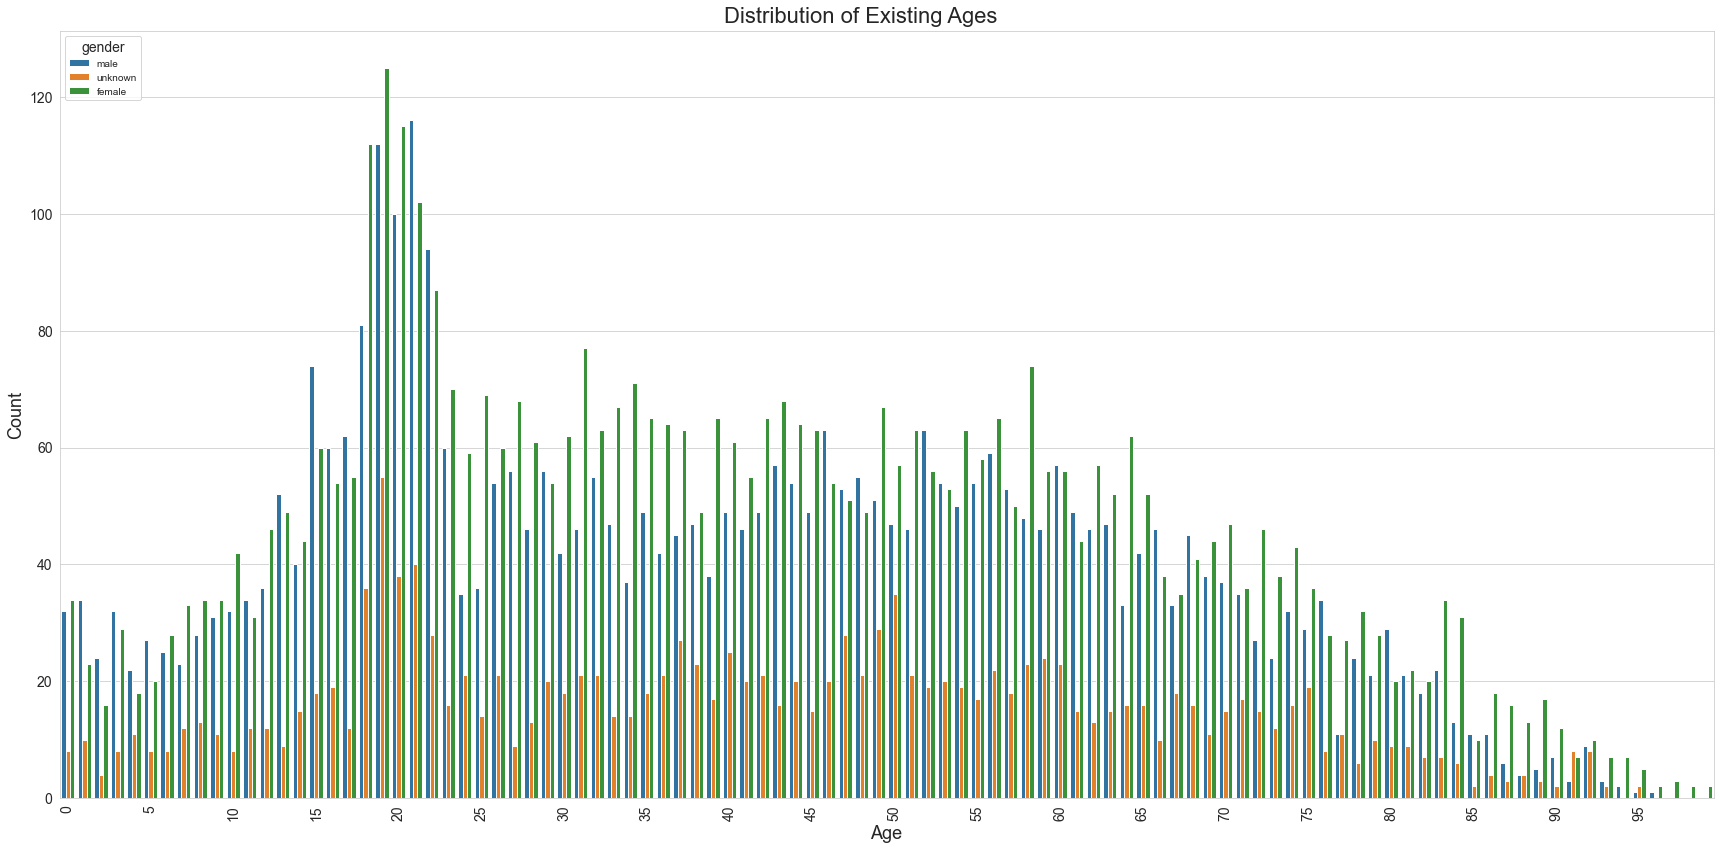

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, _ = plt.subplots(figsize=(24, 12))
sns.countplot(data=plotdata,
              x='age',
              hue='gender')
fig.suptitle('Distribution of Existing Ages', fontsize=22)
plt.xlabel('Age', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show only every 5th x-tick (aka every 5th age on x-axis)
for i, label in enumerate(ax.get_xticklabels()):
    if i % 5 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

plt.tight_layout()
fig.savefig('../plots/age_distribution.png', dpi=300)
plt.close()

In [50]:
plotdata['country'].value_counts()

USA               9656
Russia             265
Italy               10
Czech Republic       6
Germany              5
China                5
Pakistan             1
Name: country, dtype: int64

In [ ]:
import os

if not os.path.isdir('../plots/age_distribution'):
    os.mkdir('../plots/age_distribution')

In [ ]:
# Ensure that age distribution won't change for USA and check if other countries show interesting distributions
for country, age_count in plotdata['country'].value_counts().iteritems():
    fig, ax = plt.subplots(figsize=(24, 12))
    sns.countplot(data=plotdata[plotdata['country'] == country],
                  x='age',
                  hue='gender')
    fig.suptitle(f'Distribution of Existing Ages in {country}\n ({age_count} ages available)', fontsize=22)
    plt.xlabel('Age', fontsize=18)
    plt.ylabel('Count', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Show only every 5th x-tick
    for i, label in enumerate(ax.get_xticklabels()):
        if i % 5 == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)

    plt.tight_layout()
    fig.savefig(f'../plots/age_distribution/age_distribution_{country}.png', dpi=300)
    plt.close()

# USA:
# -> similiar to real-world age distribution, especially regarding rise around 20
# -> see e.g. https://www.statista.com/statistics/241488/population-of-the-us-by-sex-and-age/
# -> a bit more female samples are also quite realistic

# RUSSIA:
# -> russian ages are mostly between 63 and 83